# 准备

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")
    
def plot_color_image(image):
    plt.imshow(image.astype(np.uint8), interpolation="nearest")
    plt.axis("off")

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# 卷积层(Convolutional Layer)

In [3]:
from sklearn.datasets import load_sample_image

china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")

image = china[150:220, 130:250]

height, width, channels = image.shape

image_gray_scale = image.mean(axis=2).astype(np.float32)
images = image_gray_scale.reshape(1, height, width, 1)

In [4]:
fmap = np.zeros(shape=(7, 7, 1, 2), dtype=np.float32)
fmap[:, 3, 0, 0] = 1
fmap[3, :, 0, 1] = 1

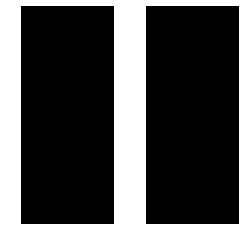

In [5]:
plot_image(fmap[:, :, 0, 0])
plt.show()

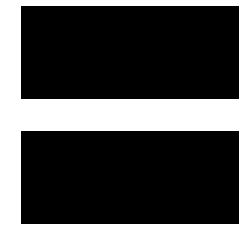

In [6]:
plot_image(fmap[:, :, 0, 1])
plt.show()

In [7]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, height, width, 1))
feature_maps = tf.constant(fmap)
covolution = tf.nn.conv2d(X, feature_maps, strides=[1, 1, 1, 1], padding="SAME")

In [8]:
with tf.Session() as sess:
    output = covolution.eval(feed_dict={X: images})

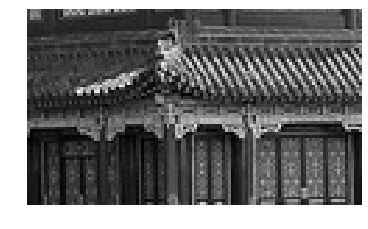

In [9]:
plot_image(images[0, :, :, 0])
plt.show()

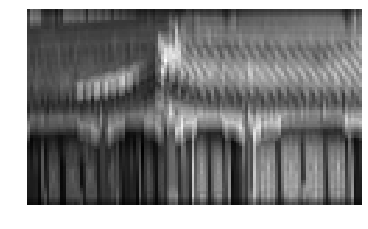

In [10]:
plot_image(output[0, :, :, 0])
plt.show()

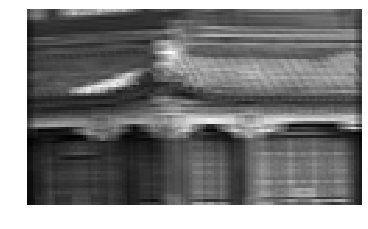

In [11]:
plot_image(output[0, :, :, 1])
plt.show()

## 例子

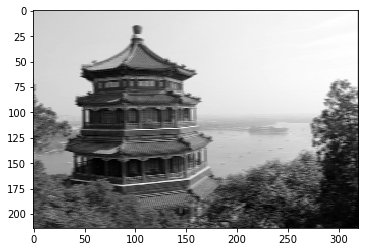

In [12]:
import numpy as np
from sklearn.datasets import load_sample_images

china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
dataset = np.array([china, flower], dtype=np.float32)
batch_size, height, width, channels = dataset.shape

# 创建两个过滤器
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 #垂直
filters[3, :, :, 1] = 1 #水平

X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
convolution = tf.nn.conv2d(X, filters, strides=[1, 2, 2, 1], padding="SAME")

with tf.Session() as sess:
    output = sess.run(convolution, feed_dict={X: dataset})

plt.imshow(output[0, :, :, 1], cmap="gray")
plt.show()

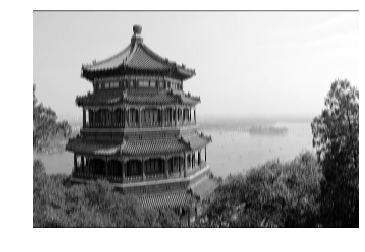

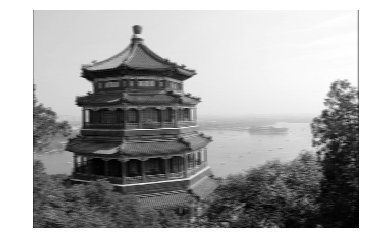

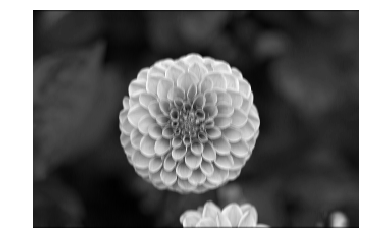

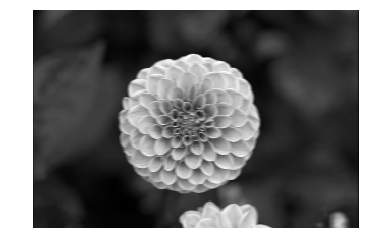

In [13]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plot_image(output[image_index, :, :, feature_map_index ])
        plt.show()

In [14]:
reset_graph()

X = tf.placeholder(shape=(None, height, width, channels), dtype=np.float32)
conv = tf.layers.conv2d(X, filters=2, kernel_size=7, strides=[2, 2], padding="SAME")

In [15]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    output = sess.run(conv, feed_dict={X: dataset})

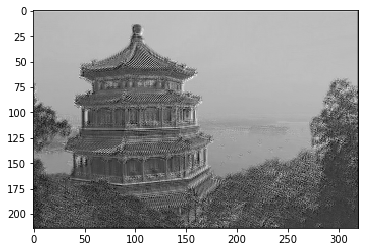

In [16]:
plt.imshow(output[0, :, :, 1], cmap="gray")
plt.show()

## VALID 和 SAME填充

In [17]:
reset_graph()

filter_primes = np.array([2., 3., 5., 7., 11., 13.], dtype=np.float32)
x = tf.constant(np.arange(1, 14, dtype=np.float32).reshape([1, 1, 13, 1]))
filters = tf.constant(filter_primes.reshape(1, 6, 1, 1))

valid_conv = tf.nn.conv2d(x, filters, strides=[1, 1, 5, 1], padding="VALID")
same_conv = tf.nn.conv2d(x, filters, strides=[1, 1, 5, 1], padding="SAME")

with tf.Session() as sess:
    print("VALID:\n", valid_conv.eval())
    print("SAME:\n", same_conv.eval())

VALID:
 [[[[184.]
   [389.]]]]
SAME:
 [[[[143.]
   [348.]
   [204.]]]]


In [18]:
print("VALID:")
print(np.array([1,2,3,4,5,6]).T.dot(filter_primes))
print(np.array([6,7,8,9,10,11]).T.dot(filter_primes))

print("SAME:")
print(np.array([0,1,2,3,4,5]).T.dot(filter_primes))
print(np.array([5,6,7,8,9,10]).T.dot(filter_primes))
print(np.array([10,11,12,13,0,0]).T.dot(filter_primes))

VALID:
184.0
389.0
SAME:
143.0
348.0
204.0


# 池化层(Pooling layer)

In [19]:
batch_size, height, width, channels = dataset.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 #垂直
filters[3, :, :, 1] = 1 #水平

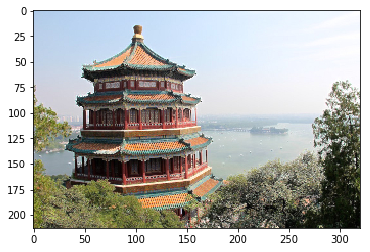

In [20]:
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
max_pool = tf.nn.max_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1], padding="VALID")

with tf.Session() as sess:
    output = sess.run(max_pool, feed_dict={X: dataset})

plt.imshow(output[0].astype(np.uint8))
plt.show()

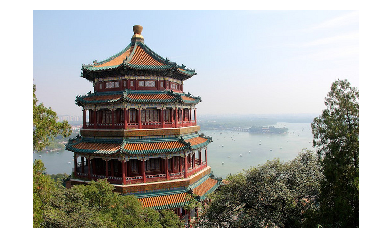

In [21]:
plot_color_image(dataset[0])
plt.show()

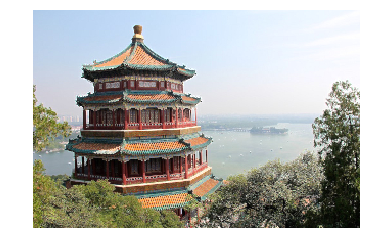

In [22]:
plot_color_image(output[0])
plt.show()

# MNIST

In [23]:
reset_graph()
height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fcl = 64
n_outputs = 10

with tf.name_scope("inputs"):
    X =  tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    
conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                        strides=conv1_stride, padding=conv1_pad, activation=tf.nn.relu,
                        name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                        strides=conv2_stride, padding=conv2_pad, activation=tf.nn.relu,
                        name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7])
    
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fcl, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [24]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./tmp/data")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./tmp/data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./tmp/data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ./tmp/data\t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ./tmp/data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [26]:
n_epochs = 10
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Training accuracy:", acc_train, "Test accuracy:", acc_test)
        
        save_path = saver.save(sess, "./cnn/my_mnist_mode")

0 Training accuracy: 0.99 Test accuracy: 0.9771
1 Training accuracy: 0.96 Test accuracy: 0.98
2 Training accuracy: 1.0 Test accuracy: 0.986
3 Training accuracy: 0.99 Test accuracy: 0.9871
4 Training accuracy: 1.0 Test accuracy: 0.9882
5 Training accuracy: 0.99 Test accuracy: 0.9903
6 Training accuracy: 1.0 Test accuracy: 0.9882
7 Training accuracy: 0.99 Test accuracy: 0.9892
8 Training accuracy: 1.0 Test accuracy: 0.9884
9 Training accuracy: 1.0 Test accuracy: 0.9882
